# Vector Autoregressive 

In [1]:
import pandas as pd
import numpy as np

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests

## Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

## Import random
import random

## Test standardScaler and its inverse

In [2]:
data = [[1, 1], [2, 3], [3, 2], [1, 1]]
scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)
print (scaled)

# for inverse transformation
inversed = scaler.inverse_transform(scaled)
print(inversed)

[[-0.90453403 -0.90453403]
 [ 0.30151134  1.50755672]
 [ 1.50755672  0.30151134]
 [-0.90453403 -0.90453403]]
[[1. 1.]
 [2. 3.]
 [3. 2.]
 [1. 1.]]


## Read the file

In [3]:
df = pd.read_csv('../Data/dataset_others.csv')
# Extract _change_in_price columns
change_in_price_cols = [col for col in df.columns if '_change_in_price' in col]
df_change = df[change_in_price_cols].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Columns: 155 entries, Date to F_Bollinger_Lower
dtypes: float64(154), object(1)
memory usage: 1.5+ MB


In [4]:
F_cols = [col for col in df.columns if 'F_' in col]

In [5]:
F_cols

['F_Open',
 'F_Close_pred',
 'F_High',
 'F_Low',
 'F_Volume',
 'F_Change',
 'F_Gain',
 'F_Loss',
 'F_Avg_Gain',
 'F_Avg_Loss',
 'F_SMA',
 'F_EMA',
 'F_change_in_price',
 'F_RSI',
 'F_k_percent',
 'F_r_percent',
 'F_MACD',
 'F_MACD_EMA',
 'F_ROC',
 'F_PVT',
 'F_Bollinger_Upper',
 'F_Bollinger_Lower']

In [6]:
df_change

,CADUSD=X_change_in_price,GM_change_in_price,JCI_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,^IXIC_change_in_price,F_change_in_price
0,-0.000418,0.099998,0.330002,-0.569992,-0.000812,15.439453,0.010000
1,0.001932,0.230000,0.160000,-0.309998,-0.000532,57.250000,0.090000
2,-0.000607,-0.139999,-0.279999,-1.449997,0.000039,-39.709961,-0.040000
3,-0.000238,-0.119999,-0.560001,0.059998,0.000314,-97.479492,-0.050000
4,-0.001081,-0.350002,-0.480000,0.459991,0.000223,-47.350586,-0.120000
...,...,...,...,...,...,...,...
1232,-0.001776,4.799999,-0.529999,0.759995,0.000026,39.759766,0.230000
1233,0.000905,-0.810001,-0.159996,1.400009,-0.000006,-303.119141,-0.049999
1234,-0.001072,-0.199997,0.379997,-0.900009,-0.000013,138.839844,0.179999
1235,-0.000866,-0.650002,-0.120003,1.570007,-0.000016,103.119141,-0.170000


In [7]:
df_change.describe()

,CADUSD=X_change_in_price,GM_change_in_price,JCI_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,^IXIC_change_in_price,F_change_in_price
count,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000
mean,-0.000026,0.013678,0.028383,0.027559,-0.000118,8.031285,0.001916
std,0.003274,1.035859,1.005309,2.645727,0.001092,188.215089,0.342177
min,-0.012518,-5.160000,-6.480000,-14.479996,-0.013081,-970.290039,-2.510000
25%,-0.001900,-0.549999,-0.470001,-1.439987,-0.000263,-87.690430,-0.150001
50%,-0.000024,0.029999,0.079994,0.100006,-0.000040,18.040039,0.000000
75%,0.001853,0.540001,0.650002,1.479996,0.000053,118.120117,0.160000
max,0.012381,4.869999,3.580002,15.830002,0.013998,760.980469,2.539999


## Tickers list

In [8]:
tickers = []
for col in df.columns:
    if '_RSI' in col:
        tickers.append(col.split('_')[0])

tickers.pop()

'F'

## Train - test set

In [9]:
# Train set for cross-validation
train = df_change.iloc[:-5].copy()
# Test set is saved for the best model
test = df_change.iloc[-5:].copy()

## Plot histograms for original scale and standardScale()

       F_change_in_price  CADUSD=X_change_in_price
count       1.232000e+03              1.232000e+03
mean       -1.441848e-18             -1.874403e-17
std         1.000406e+00              1.000406e+00
min        -7.333161e+00             -3.811584e+00
25%        -4.424276e-01             -5.728566e-01
50%        -4.455543e-03              3.563496e-03
75%         4.627124e-01              5.756020e-01
max         7.411840e+00              3.783186e+00
       F_change_in_price  GM_change_in_price
count       1.232000e+03        1.232000e+03
mean       -1.441848e-18       -1.513940e-17
std         1.000406e+00        1.000406e+00
min        -7.333161e+00       -5.030253e+00
25%        -4.424276e-01       -5.381305e-01
50%        -4.455543e-03        1.882404e-02
75%         4.627124e-01        5.149784e-01
max         7.411840e+00        4.727406e+00
       F_change_in_price  JCI_change_in_price
count       1.232000e+03         1.232000e+03
mean       -1.441848e-18         1.730218e-1

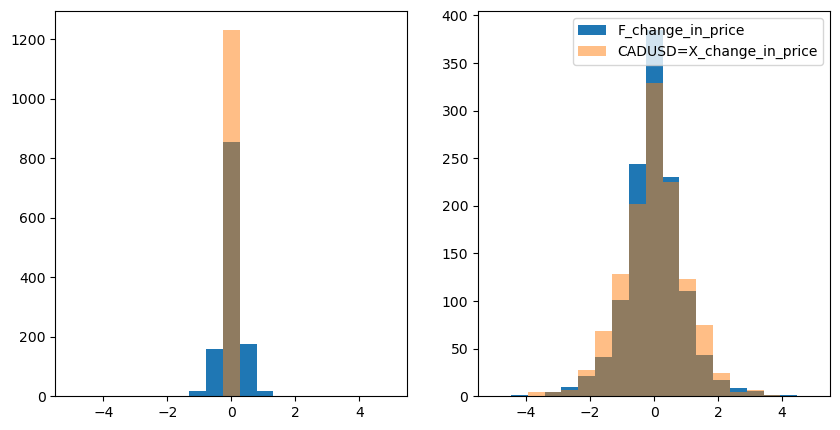

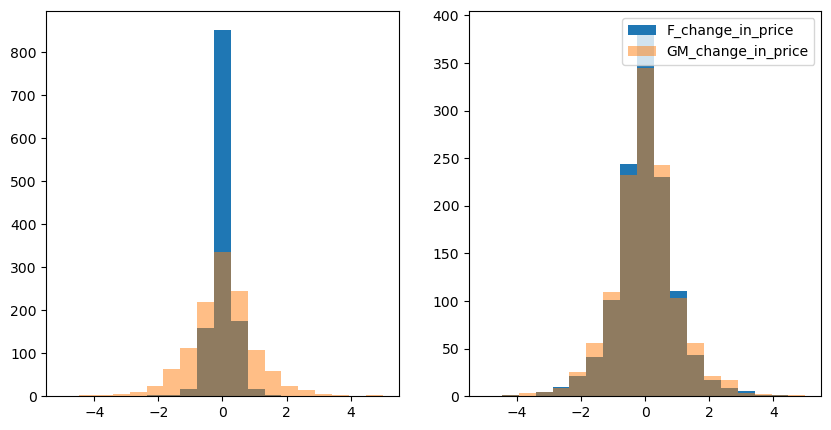

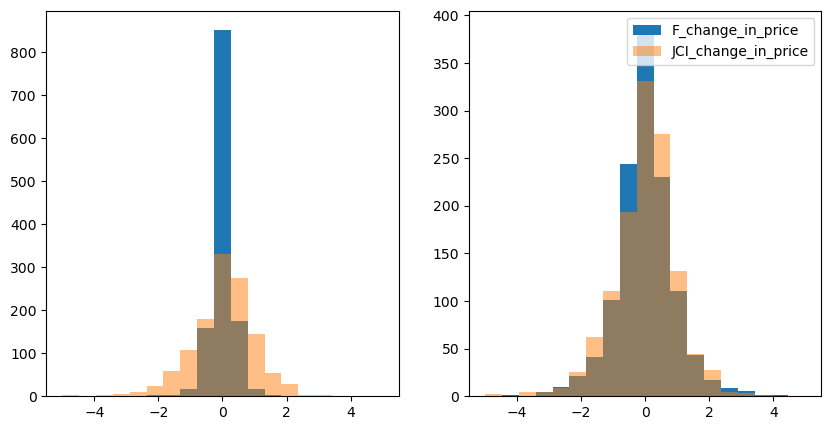

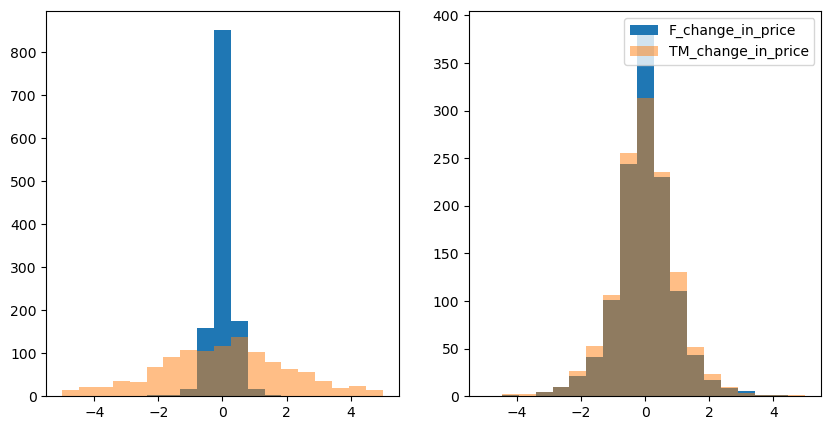

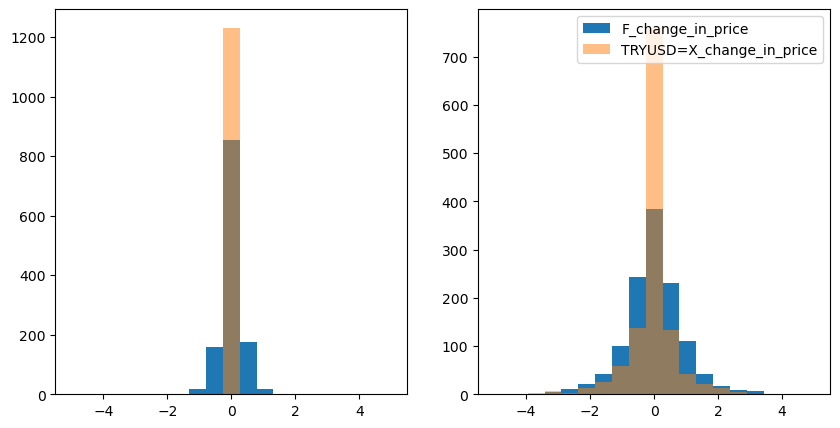

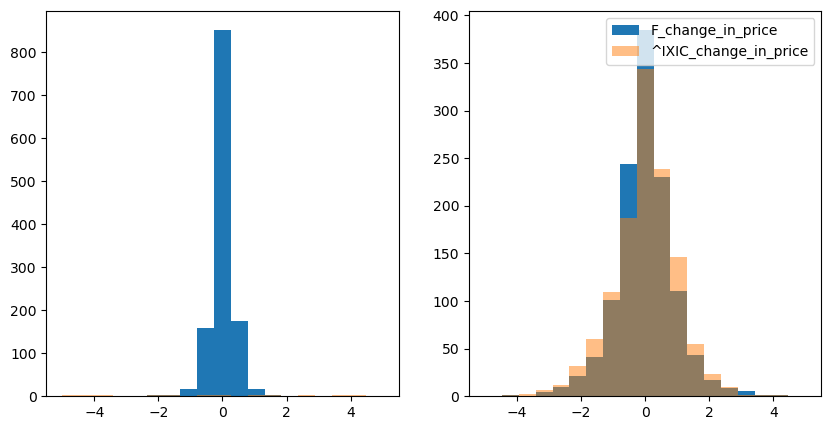

In [10]:
bins = np.linspace(-5, 5, 20)

for i in range(6):
    t = train.columns[i]
    train_fit = train[['F_change_in_price', t]].copy()
    scaler = StandardScaler()
    scaler_train = scaler.fit_transform(train_fit.values)
    scaled_train_set = pd.DataFrame(scaler_train, columns = train_fit.columns)

    print(scaled_train_set.describe())

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].hist(train_fit[change_in_price_cols[-1]], bins, label = change_in_price_cols[-1])
    axes[0].hist(train_fit[change_in_price_cols[i]], bins, label = change_in_price_cols[i], alpha = 0.5)
    axes[1].hist(scaled_train_set[change_in_price_cols[-1]], bins, label = change_in_price_cols[-1])
    axes[1].hist(scaled_train_set[change_in_price_cols[i]], bins, label = change_in_price_cols[i], alpha = 0.5)
    plt.legend()

## Cross validation for each ticker model

In [11]:
def best_VAR(train, forecast_length = 5):
    cv = TimeSeriesSplit(10, test_size=forecast_length)
    MSE = np.zeros(40) # Smallest order should be 1
    
    for train_index, test_index in cv.split(train):
        t_tt = train.iloc[train_index]
        t_ho = train.iloc[test_index]
        model = VAR(t_tt)
        for i in range(1, 41):
            var_model = model.fit(i)
            pred = var_model.forecast(t_tt[-i:].values, steps=forecast_length)
            MSE[i - 1] = np.sqrt(mean_squared_error(t_ho['F_change_in_price'].values, pred[:, 0]))
    
    order_optimal = np.argmin(MSE) + 1
    print(sum(predictions[t]*predictions['F_change_in_price'] > 0)/5)
    
    return order_optimal

## Compute Optimal Lag

In [12]:
c = ['Ticker', 'Optimal order', 'Accuracy']
accuracy = pd.DataFrame(columns=c)
for i, t in enumerate(tickers):
    accuracy.loc[i, 'Ticker'] = t.split('_')[0]
accuracy

,Ticker,Optimal order,Accuracy
0,CADUSD=X,NaN,NaN
1,GM,NaN,NaN
2,JCI,NaN,NaN
3,TM,NaN,NaN
4,TRYUSD=X,NaN,NaN
5,^IXIC,NaN,NaN


In [13]:
for i in range(len(change_in_price_cols) - 1):
    tr_set = train[[change_in_price_cols[-1], change_in_price_cols[i]]]
    scaler = StandardScaler()
    # Scaled the train set
    scaler_train = scaler.fit_transform(tr_set.values)
    scaled_train_set = pd.DataFrame(scaler_train, columns = tr_set.columns)
    accuracy.loc[i, 'Optimal order'] = best_VAR(scaled_train_set, 5)

In [14]:
accuracy

,Ticker,Optimal order,Accuracy
0,CADUSD=X,12,NaN
1,GM,12,NaN
2,JCI,15,NaN
3,TM,22,NaN
4,TRYUSD=X,2,NaN
5,^IXIC,15,NaN


## Forecasting test_set

In [15]:
prediction_cols = []
for t in tickers:
    prediction_cols.append(t + '_VAR')

predictions = pd.DataFrame(columns=prediction_cols, index=test.index)
predictions

,CADUSD=X_VAR,GM_VAR,JCI_VAR,TM_VAR,TRYUSD=X_VAR,^IXIC_VAR
1232,NaN,NaN,NaN,NaN,NaN,NaN
1233,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN
1235,NaN,NaN,NaN,NaN,NaN,NaN
1236,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
for i in range(6):
    t = prediction_cols[i]
    train_fit = train[[change_in_price_cols[-1], change_in_price_cols[i]]].copy()
    scaler = StandardScaler()
    # Scaled the train set
    scaler_train = scaler.fit_transform(train_fit.values)
    scaled_train_set = pd.DataFrame(scaler_train, columns = train_fit.columns)
    model = VAR(scaled_train_set)
    k = accuracy.loc[i, 'Optimal order']
    results = model.fit(k)
    # Inverse scale
    pred = scaler.inverse_transform(results.forecast(scaled_train_set.values[-k:], steps=5))
    predictions.loc[:, t] = pred[:, 0]

In [17]:
predictions = pd.concat([predictions, test['F_change_in_price']], axis=1)
predictions

,CADUSD=X_VAR,GM_VAR,JCI_VAR,TM_VAR,TRYUSD=X_VAR,^IXIC_VAR,F_change_in_price
1232,-0.033737,-0.012626,0.029559,0.022957,-0.007467,0.088103,0.230000
1233,-0.039427,-0.008978,-0.070183,0.068173,-0.001447,-0.010875,-0.049999
1234,-0.07565,-0.035802,0.054384,0.019441,0.001707,0.004646,0.179999
1235,0.001048,-0.024874,0.05439,-0.065639,0.000836,0.025414,-0.170000
1236,-0.016464,-0.016876,-0.02205,0.015446,0.001415,-0.018408,0.300000


In [18]:
predictions

,CADUSD=X_VAR,GM_VAR,JCI_VAR,TM_VAR,TRYUSD=X_VAR,^IXIC_VAR,F_change_in_price
1232,-0.033737,-0.012626,0.029559,0.022957,-0.007467,0.088103,0.230000
1233,-0.039427,-0.008978,-0.070183,0.068173,-0.001447,-0.010875,-0.049999
1234,-0.07565,-0.035802,0.054384,0.019441,0.001707,0.004646,0.179999
1235,0.001048,-0.024874,0.05439,-0.065639,0.000836,0.025414,-0.170000
1236,-0.016464,-0.016876,-0.02205,0.015446,0.001415,-0.018408,0.300000


## Fill in accuracy column

In [19]:
for i in range(len(change_in_price_cols) - 1):
    t = accuracy.loc[i, 'Ticker'] + '_VAR'
    accuracy.loc[i, 'Accuracy'] = sum(predictions[t]*predictions['F_change_in_price'] > 0)/5

In [59]:
for i in range(len(change_in_price_cols) - 1):
    t = accuracy.loc[i, 'Ticker'] + '_VAR'
    print(t)
    print(predictions[t], predictions['F_change_in_price'])

CADUSD=X_VAR
1232   -0.033737
1233   -0.039427
1234    -0.07565
1235    0.001048
1236   -0.016464
Name: CADUSD=X_VAR, dtype: object 1232    0.230000
1233   -0.049999
1234    0.179999
1235   -0.170000
1236    0.300000
Name: F_change_in_price, dtype: float64
GM_VAR
1232   -0.012626
1233   -0.008978
1234   -0.035802
1235   -0.024874
1236   -0.016876
Name: GM_VAR, dtype: object 1232    0.230000
1233   -0.049999
1234    0.179999
1235   -0.170000
1236    0.300000
Name: F_change_in_price, dtype: float64
JCI_VAR
1232    0.029559
1233   -0.070183
1234    0.054384
1235     0.05439
1236    -0.02205
Name: JCI_VAR, dtype: object 1232    0.230000
1233   -0.049999
1234    0.179999
1235   -0.170000
1236    0.300000
Name: F_change_in_price, dtype: float64
TM_VAR
1232    0.022957
1233    0.068173
1234    0.019441
1235   -0.065639
1236    0.015446
Name: TM_VAR, dtype: object 1232    0.230000
1233   -0.049999
1234    0.179999
1235   -0.170000
1236    0.300000
Name: F_change_in_price, dtype: float64
TRYUSD

In [20]:
accuracy

,Ticker,Optimal order,Accuracy
0,CADUSD=X,12,0.2
1,GM,12,0.4
2,JCI,15,0.6
3,TM,22,0.8
4,TRYUSD=X,2,0.6
5,^IXIC,15,0.6


## Compute F_close from VAR predictions change_in_price

In [21]:
df_close = df[['F_Close_pred']].copy()
df_close[-6:] 

,F_Close_pred
1231,10.88
1232,11.11
1233,11.06
1234,11.24
1235,11.07
1236,11.37


In [22]:
len(df_close)

1237

In [23]:
VAR_predictions = predictions.copy()

In [24]:
df_close.loc[1236 - 5, 'F_Close_pred']

np.float64(10.880000114440918)

In [25]:
'''n = len(df_close)
for t in VAR_predictions.columns:
    VAR_predictions.loc[n - 5, t] += df_close.loc[n - 1, 'F_Close_pred'] '''

"n = len(df_close)\nfor t in VAR_predictions.columns:\n    VAR_predictions.loc[n - 5, t] += df_close.loc[n - 1, 'F_Close_pred'] "

In [26]:
n = len(df)
for t in VAR_predictions.columns:
    VAR_predictions[t] = df.loc[n - 6, 'F_Close_pred'] + predictions[t].cumsum()

In [27]:
VAR_predictions

,CADUSD=X_VAR,GM_VAR,JCI_VAR,TM_VAR,TRYUSD=X_VAR,^IXIC_VAR,F_change_in_price
1232,10.846263,10.867374,10.90956,10.902957,10.872533,10.968103,11.11
1233,10.806837,10.858396,10.839376,10.97113,10.871086,10.957228,11.06
1234,10.731186,10.822595,10.89376,10.990572,10.872793,10.961874,11.24
1235,10.732235,10.797721,10.948151,10.924932,10.873629,10.987288,11.07
1236,10.71577,10.780844,10.926101,10.940378,10.875044,10.96888,11.37


In [28]:
#df_close.loc[n - 5, 'F_Close_pred'] + predictions['CADUSD=X_VAR'].cumsum()

In [29]:
# predictions['CADUSD=X_VAR'].cumsum()

## Create 10 ticker marks for date axis

In [30]:
def x_ticks(df, no_of_ticks = 10):
    
    x = [x for x in range(df.index[0], df.index[-1], int(len(df)/no_of_ticks))]
    #x.append(df.index[-1])
    dates = pd.to_datetime(df['Date'].copy())
    dates = dates.dt.strftime('%d/%m/%Y')
    date_ticker = [d for d in dates.loc[x]]

    return x, date_ticker

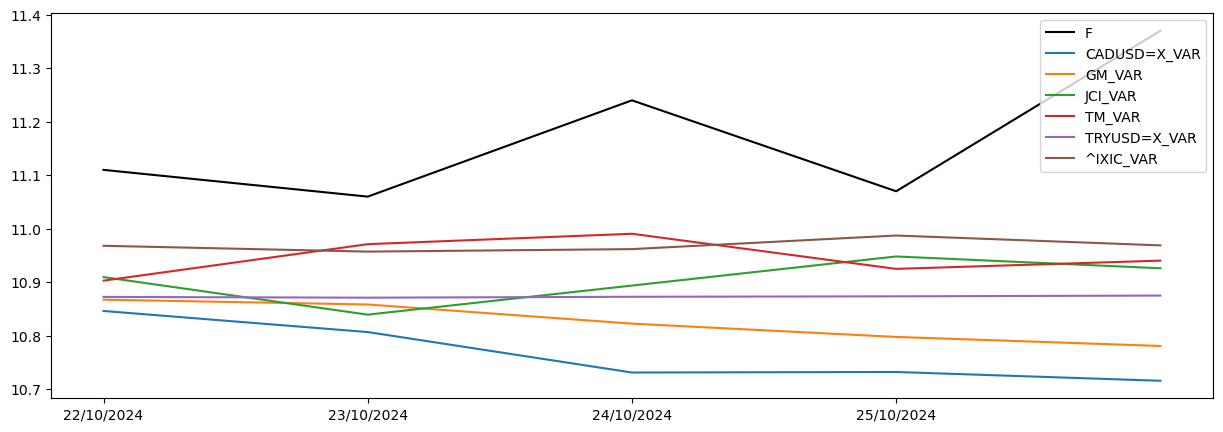

In [31]:
x, date_ticker = x_ticks(df[-5:], 5)
plt.figure(figsize=(15, 5))
plt.plot(df['F_Close_pred'][-5:], color='k', label = 'F')
for t in VAR_predictions.columns:
    if t != 'F_change_in_price':
        plt.plot(VAR_predictions[t], label = t)
plt.xticks(x, date_ticker)
plt.legend()
plt.show()

## Backtesting

## Choosing 10 sets

In [32]:
df['Date'] = pd.to_datetime(df['Date'])

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Columns: 155 entries, Date to F_Bollinger_Lower
dtypes: datetime64[ns, UTC](1), float64(154)
memory usage: 1.5 MB


In [35]:
df.shape

(1237, 155)

In [37]:
forecast_length = 1
idx = random.choice(range(123 - (22 + forecast_length)))
idx

32

In [38]:
idx+22

54

In [49]:
size = len(df) // 10
forecast_length = 1
rng = np.random.RandomState(42)

for i in range(10):
    ch = rng.randint(i*size + (22 + forecast_length), (i + 1)*size - (22 + forecast_length))
    print(ch)

74
160
340
452
535
712
835
907
1009
1151


In [57]:
for i in range(10):
    ch2 = rng.randint(i*size + (22 + 2), (i + 1)*size - (22 + 2))
    print(ch2)

76
148
299
430
517
702
821
905
1040
1188


In [58]:
for i in range(10):
    ch3 = rng.randint(i*size + (22 + 3), (i + 1)*size - (22 + 3))
    print(ch3)

46
196
329
435
576
654
824
947
1055
1193


In [56]:
df[ch:ch + 22]

,Date,CADUSD=X_Open,CADUSD=X_Close,CADUSD=X_High,CADUSD=X_Low,CADUSD=X_Volume,CADUSD=X_Change,CADUSD=X_Gain,CADUSD=X_Loss,CADUSD=X_Avg_Gain,...,F_change_in_price,F_RSI,F_k_percent,F_r_percent,F_MACD,F_MACD_EMA,F_ROC,F_PVT,F_Bollinger_Upper,F_Bollinger_Lower
1151,2024-06-26 00:00:00+00:00,0.732005,0.732005,0.732558,0.729794,0.0,-0.000171,0.000000,0.000171,0.000611,...,0.020000,54.675353,57.731888,-42.268112,-0.047977,-0.079719,-0.329218,1.169355e+08,12.400566,11.602434
1152,2024-06-27 00:00:00+00:00,0.729687,0.729687,0.731203,0.729294,0.0,-0.002318,0.000000,0.002318,0.000611,...,0.120000,59.741452,70.103007,-29.896993,-0.027601,-0.069295,-1.211636,1.174120e+08,12.387823,11.682177
1153,2024-06-28 00:00:00+00:00,0.729964,0.729964,0.731315,0.728157,0.0,0.000277,0.000277,0.000000,0.000548,...,0.310000,69.802438,92.523369,-7.476631,0.013407,-0.052755,3.550787,1.190828e+08,12.469919,11.677080
1154,2024-07-01 00:00:00+00:00,0.731384,0.731384,0.731893,0.727416,0.0,0.001420,0.001420,0.000000,0.000649,...,0.220000,74.932300,91.666691,-8.333309,0.062932,-0.029618,5.629142,1.200679e+08,12.606513,11.603486
1155,2024-07-02 00:00:00+00:00,0.727919,0.727919,0.730407,0.727014,0.0,-0.003466,0.000000,0.003466,0.000649,...,0.110000,77.169784,94.285718,-5.714282,0.109792,-0.001736,7.788948,1.204730e+08,12.745904,11.532096
1156,2024-07-03 00:00:00+00:00,0.731165,0.731165,0.734355,0.730663,0.0,0.003247,0.003247,0.000000,0.000858,...,0.000000,77.169784,93.617010,-6.382990,0.145255,0.027662,9.906062,1.204730e+08,12.867222,11.494777
1157,2024-07-05 00:00:00+00:00,0.734473,0.734473,0.735240,0.732456,0.0,0.003308,0.003308,0.000000,0.000969,...,-0.030000,74.747290,91.489369,-8.510631,0.168990,0.055928,8.354428,1.203993e+08,12.963472,11.475528
1158,2024-07-08 00:00:00+00:00,0.733245,0.733245,0.733999,0.732821,0.0,-0.001228,0.000000,0.001228,0.000969,...,0.139999,78.398638,85.806436,-14.193564,0.196828,0.084108,10.186756,1.208829e+08,13.078530,11.451470
1159,2024-07-09 00:00:00+00:00,0.733703,0.733703,0.733783,0.732756,0.0,0.000457,0.000457,0.000000,0.000971,...,-0.080000,71.574972,80.645151,-19.354849,0.210014,0.109289,8.040202,1.206321e+08,13.161578,11.443421
1160,2024-07-10 00:00:00+00:00,0.733676,0.733676,0.734916,0.733020,0.0,-0.000027,0.000000,0.000027,0.000897,...,0.270000,78.770614,97.435901,-2.564099,0.239490,0.135330,11.233107,1.213920e+08,13.284664,11.399336


In [55]:
test[1][1]

[3, 4]

In [50]:
x = np.arange(100)
cv_test = TimeSeriesSplit(n_splits=10, max_train_size=22 ,test_size=5)
for train_index, test_index in cv_test.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49] TEST: [50 51 52 53 54]
TRAIN: [33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54] TEST: [55 56 57 58 59]
TRAIN: [38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59] TEST: [60 61 62 63 64]
TRAIN: [43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] TEST: [65 66 67 68 69]
TRAIN: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69] TEST: [70 71 72 73 74]
TRAIN: [53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74] TEST: [75 76 77 78 79]
TRAIN: [58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79] TEST: [80 81 82 83 84]
TRAIN: [63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84] TEST: [85 86 87 88 89]
TRAIN: [68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89] TEST: [90 91 92 93 94]
TRAIN: [73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94] TEST: [95 96 97 98 99]


In [ ]:
cv_test_2 = TimeSeriesSplit(n_splits=10)
for train_index, test_index in cv_test_2.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)

In [ ]:
df_back_test = df[['F_change_in_price', 'TM_change_in_price']].copy()
train = df_back_test[:-5]
test = df_back_test[-5:]

In [ ]:
train

In [ ]:
for train_index, test_index in cv_test.split(train):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train.values)
    scaled_train_set = pd.DataFrame(scaled_train, columns = train.columns)
    t_tt = scaled_train_set.iloc[train_index]
    t_ho = scaled_train_set.iloc[test_index]
    model = VAR(t_tt)
    #for i in range(1, 41):
    var_model = model.fit(22)
    pred = var_model.forecast(t_tt.values, steps=5)
    MSE[i - 1] = np.sqrt(mean_squared_error(t_ho['F_change_in_price'].values, pred[:, 0]))